In [4]:
import numpy as np
import h5py
import pandas as pd
import torch

In [5]:
#read 0B68620 and 0B68720

with h5py.File('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/annotated_slides/0B87711/0B87711.hdf5',mode='r') as f:
    skbr3_images = f['images'][:]
    skbr3_masks = f['masks'][:]
sk_features = pd.read_hdf('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/annotated_slides/0B87711/0B87711.hdf5',key='features',mode='r')

with h5py.File('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/annotated_slides/0B68720/0B68720.hdf5',mode='r') as f:
    hpaec_images = f['images'][:]
    hpaec_masks = f['masks'][:]
hp_features = pd.read_hdf('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/annotated_slides/0B68720/0B68720.hdf5',key='features',mode='r')

#merge image arrays
images = np.concatenate((skbr3_images,hpaec_images),axis=0)
masks = np.concatenate((skbr3_masks,hpaec_masks),axis=0)
features = pd.concat([sk_features,hp_features],axis=0)

#labels
labels = features['label'].values

#convert labels to np array
labels = np.array(labels)

In [6]:
print(images.shape)
print(masks.shape)
print(labels.shape)

(7727, 75, 75, 4)
(7727, 75, 75, 1)
(7727,)


In [7]:
print(features['label'].value_counts())

0    6636
1     683
2     408
Name: label, dtype: int64


In [8]:
#append src to path
#set path for importing modules
import os
import sys

# Get the notebook's directory and go up to project root
notebook_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))
sys.path.append(project_root)

from src.representation_learning.data_loader import get_data_loaders
from src.representation_learning.model_cl import CL
import src.utils.utils as utils

In [9]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [10]:
#model
model_path = '/mnt/deepstore/Final_DeepPhenotyping/pipeline/model_weights/representation_learning_04_28.pth'
model = CL(in_channels=5, h_dim=128, projection_dim=64)
state_dict = torch.load(model_path)['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
model.to('cuda')

CL(
  (encoder): Encoder(
    (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adap_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=256, out_features=128, bias=True)
  )
  (projector): Sequential(
    (0): Linear(in_features=128, out_features=128, bia

In [11]:
from src.representation_learning.data_loader import CustomImageDataset

dataset = CustomImageDataset(images, masks, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=False)

In [12]:
device = 'cuda:0'

In [51]:
embeddings = utils.get_embeddings(model, dataloader, device)

embeddings = embeddings.numpy()

embeddings_df = pd.DataFrame(
    embeddings.astype('float16'),
    columns=[f'z{i}' for i in range(embeddings.shape[1])])

In [52]:
#now we have the embeddings, we can use them to train a classifier. Let's train a 2 layer MLP with torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim

In [76]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_df, labels, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train.values).float().to(device)
X_test = torch.tensor(X_test.values).float().to(device)
y_train = torch.tensor(y_train).long().to(device)
y_test = torch.tensor(y_test).long().to(device)

class MLP(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(h_dim, h_dim//2)
        self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(h_dim//2, out_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dp1(x)
        x = torch.relu(self.fc2(x))
        x = self.dp2(x)
        x = self.fc3(x)
        return x

In [77]:
MLP_model = MLP(in_dim=128, h_dim=32, out_dim=3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(MLP_model.parameters(), lr=0.01, weight_decay=0.0001)

n_epochs = 100



In [78]:
train_losses = []
test_losses = []

In [79]:
for epoch in range(n_epochs):
    MLP_model.train()
    optimizer.zero_grad()
    y_pred = MLP_model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        train_losses.append(loss.item())

    #validation
    MLP_model.eval()
    y_pred = MLP_model(X_test)
    loss = criterion(y_pred, y_test)
    print(f'Validation Loss {loss.item()}')
    test_losses.append(loss.item())



Epoch 0, Loss 1.5954318046569824
Validation Loss 0.7841607928276062
Epoch 1, Loss 0.9551361203193665
Validation Loss 0.5730305314064026
Epoch 2, Loss 0.7478360533714294
Validation Loss 0.4415622353553772
Epoch 3, Loss 0.6503586769104004
Validation Loss 0.3495004177093506
Epoch 4, Loss 0.5589647889137268
Validation Loss 0.2819705903530121
Epoch 5, Loss 0.4955413341522217
Validation Loss 0.23386719822883606
Epoch 6, Loss 0.4307166337966919
Validation Loss 0.19937260448932648
Epoch 7, Loss 0.3785342276096344
Validation Loss 0.17561577260494232
Epoch 8, Loss 0.3472133278846741
Validation Loss 0.15820570290088654
Epoch 9, Loss 0.31153756380081177
Validation Loss 0.14465077221393585
Epoch 10, Loss 0.28251469135284424
Validation Loss 0.13361462950706482
Epoch 11, Loss 0.25729256868362427
Validation Loss 0.12461712956428528
Epoch 12, Loss 0.2324652075767517
Validation Loss 0.11651598662137985
Epoch 13, Loss 0.21774327754974365
Validation Loss 0.11056561022996902
Epoch 14, Loss 0.20089356601238

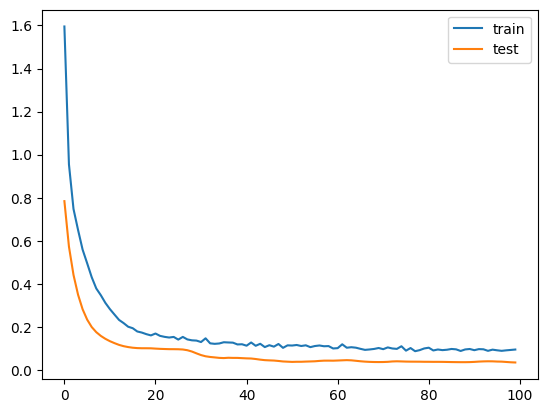

In [80]:
#plot losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()


In [81]:
#accuracy
y_pred = MLP_model(X_test)
y_pred = torch.argmax(y_pred, dim=1)
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(f'Accuracy: {accuracy}')



Accuracy: 0.9954721862871928


In [84]:
#save model
torch.save(MLP_model.state_dict(), '/mnt/deepstore/Final_DeepPhenotyping/pipeline/model_weights/spikein_model_04_30.pth')

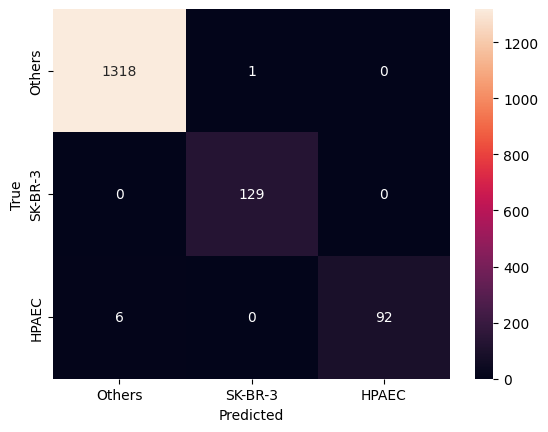

In [83]:
#create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = MLP_model(X_test)
y_pred = torch.argmax(y_pred, dim=1)
cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
sns.heatmap(cm, annot=True, fmt='d')

#add x and y label with predicted and true 
plt.xlabel('Predicted')
plt.ylabel('True')

#add x and y ticks with class names
plt.xticks(ticks=[0.5,1.5,2.5], labels=['Others', 'SK-BR-3', 'HPAEC'])
plt.yticks(ticks=[0.5,1.5,2.5], labels=['Others', 'SK-BR-3', 'HPAEC'])
plt.show()
